In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from imblearn.over_sampling import SMOTE
from imblearn.metrics import specificity_score
from sklearn.metrics import roc_curve, auc


In [3]:
import pandas as pd
import numpy as np
import polars as pl
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split


In [4]:
''' You see we have first used polars library to read the dataset and then converted it to Pandas
data frame. The reason is that Pandas was not reading some of the attribute data types correctly.
Specifically, it was considering object dtype for int and float type variables'''

df=pl.read_excel('troubling_Churn_dataset.xlsx')
df=df.to_pandas()

In [5]:
df


__UNNAMED__0  LoyaltyID Senior Citizen Partner Dependents  Tenure  \
0                0     318537             No     Yes         No       1   
1                1     152148             No      No         No      34   
2                2     326527             No      No         No       2   
3                3     845894             No      No         No      45   
4                4     503388             No      No         No       2   
...            ...        ...            ...     ...        ...     ...   
7038          7038     810338             No     Yes        Yes      24   
7039          7039     230811             No     Yes        Yes      72   
7040          7040     155157             No     Yes        Yes      11   
7041          7041     731782            Yes     Yes         No       4   
7042          7042     353947             No      No         No      66   

     Phone Service    Multiple Lines Internet Service Online Security  ...  \
0               No  No phone service              DSL              No  ...   
1              Yes                No              DSL             Yes  ...   
2              Yes                No              DSL             Yes  ...   
3               No  No phone service              DSL             Yes  ...   
4              Yes                No      Fiber optic              No  ...   
...            ...               ...              ...             ...  ...   
7038           Yes               Yes              DSL             Yes  ...   
7039           Yes               Yes      Fiber optic              No  ...   
7040            No  No phone service              DSL             Yes  ...   
7041           Yes               Yes      Fiber optic              No  ...   
7042           Yes                No      Fiber optic             Yes  ...   

     Device Protection Tech Support Streaming TV Streaming Movies  \
0                   No           No           No               No   
1                  Yes           No           No               No   
2                   No           No           No               No   
3                  Yes          Yes           No               No   
4                   No           No           No               No   
...                ...          ...          ...              ...   
7038               Yes          Yes          Yes              Yes   
7039               Yes           No          Yes              Yes   
7040                No           No           No               No   
7041                No           No           No               No   
7042               Yes          Yes          Yes              Yes   

            Contract Paperless Billing             Payment Method  \
0     Month-to-month               Yes           Electronic check   
1           One year                No               Mailed check   
2     Month-to-month               Yes               Mailed check   
3           One year                No  Bank transfer (automatic)   
4     Month-to-month               Yes           Electronic check   
...              ...               ...                        ...   
7038        One year               Yes               Mailed check   
7039        One year               Yes    Credit card (automatic)   
7040  Month-to-month               Yes           Electronic check   
7041  Month-to-month               Yes               Mailed check   
7042        Two year               Yes  Bank transfer (automatic)   

     Monthly Charges  Total Charges  Churn  
0              29.85          29.85     No  
1              56.95        1889.50     No  
2              53.85         108.15    Yes  
3              42.30        1840.75     No  
4              70.70         151.65    Yes  
...              ...            ...    ...  
7038           84.80        1990.50     No  
7039          103.20        7362.90     No  
7040           29.60         346.45     No  
7041           74.40         306.60    Yes  
7042          1


# Null Check

In [6]:
df.dtypes

__UNNAMED__0           int64
LoyaltyID              int64
Senior Citizen        object
Partner               object
Dependents            object
Tenure                 int64
Phone Service         object
Multiple Lines        object
Internet Service      object
Online Security       object
Online Backup         object
Device Protection     object
Tech Support          object
Streaming TV          object
Streaming Movies      object
Contract              object
Paperless Billing     object
Payment Method        object
Monthly Charges      float64
Total Charges        float64
Churn                 object
dtype: object

In [7]:
df.isna().sum()

__UNNAMED__0          0
LoyaltyID             0
Senior Citizen        0
Partner               0
Dependents            0
Tenure                0
Phone Service         0
Multiple Lines        0
Internet Service      0
Online Security       0
Online Backup         0
Device Protection     0
Tech Support          0
Streaming TV          0
Streaming Movies      0
Contract              0
Paperless Billing     0
Payment Method        0
Monthly Charges       0
Total Charges        11
Churn                 0
dtype: int64

In [8]:
# Since a small fraction of the dataset, less than 1%, is missing. We can use dropna()
df=df.dropna()


In [9]:
columns_continuous= [column for column in df.columns if df[column].dtype=='float64' or df[column].dtype=='int64' ]

In [10]:
categorical= [column for column in df.columns if df[column].dtype=='object' or column=='Customer ID']

In [11]:
df[categorical]

Senior Citizen Partner Dependents Phone Service    Multiple Lines  \
0                No     Yes         No            No  No phone service   
1                No      No         No           Yes                No   
2                No      No         No           Yes                No   
3                No      No         No            No  No phone service   
4                No      No         No           Yes                No   
...             ...     ...        ...           ...               ...   
7038             No     Yes        Yes           Yes               Yes   
7039             No     Yes        Yes           Yes               Yes   
7040             No     Yes        Yes            No  No phone service   
7041            Yes     Yes         No           Yes               Yes   
7042             No      No         No           Yes                No   

     Internet Service Online Security Online Backup Device Protection  \
0                 DSL              No           Yes                No   
1                 DSL             Yes            No               Yes   
2                 DSL             Yes           Yes                No   
3                 DSL             Yes            No               Yes   
4         Fiber optic              No            No                No   
...               ...             ...           ...               ...   
7038              DSL             Yes            No               Yes   
7039      Fiber optic              No           Yes               Yes   
7040              DSL             Yes            No                No   
7041      Fiber optic              No            No                No   
7042      Fiber optic             Yes            No               Yes   

     Tech Support Streaming TV Streaming Movies        Contract  \
0              No           No               No  Month-to-month   
1              No           No               No        One year   
2              No           No               No  Month-to-month   
3             Yes           No               No        One year   
4              No           No               No  Month-to-month   
...           ...          ...              ...             ...   
7038          Yes          Yes              Yes        One year   
7039           No          Yes              Yes        One year   
7040           No           No               No  Month-to-month   
7041           No           No               No  Month-to-month   
7042          Yes          Yes              Yes        Two year   

     Paperless Billing             Payment Method Churn  
0                  Yes           Electronic check    No  
1                   No               Mailed check    No  
2                  Yes               Mailed check   Yes  
3                   No  Bank transfer (automatic)    No  
4                  Yes           Electronic check   Yes  
...                ...                        ...   ...  
7038               Yes               Mailed check    No  
7039               Yes    Credit card (automatic)    No  
7040               Yes           Electronic check    No  
7041               Yes               Mailed check   Yes  
7042               Yes  Bank transfer (automatic)    No  

[7032 rows x 16 columns]

In [12]:
encoder= OrdinalEncoder()
df_categ= encoder.fit_transform(df[categorical])

In [13]:
df_temp= pd.DataFrame(data=df_categ, columns=categorical)
df_temp

Senior Citizen  Partner  Dependents  Phone Service  Multiple Lines  \
0                0.0      1.0         0.0            0.0             1.0   
1                0.0      0.0         0.0            1.0             0.0   
2                0.0      0.0         0.0            1.0             0.0   
3                0.0      0.0         0.0            0.0             1.0   
4                0.0      0.0         0.0            1.0             0.0   
...              ...      ...         ...            ...             ...   
7027             0.0      1.0         1.0            1.0             2.0   
7028             0.0      1.0         1.0            1.0             2.0   
7029             0.0      1.0         1.0            0.0             1.0   
7030             1.0      1.0         0.0            1.0             2.0   
7031             0.0      0.0         0.0            1.0             0.0   

      Internet Service  Online Security  Online Backup  Device Protection  \
0                  0.0              0.0            2.0                0.0   
1                  0.0              2.0            0.0                2.0   
2                  0.0              2.0            2.0                0.0   
3                  0.0              2.0            0.0                2.0   
4                  1.0              0.0            0.0                0.0   
...                ...              ...            ...                ...   
7027               0.0              2.0            0.0                2.0   
7028               1.0              0.0            2.0                2.0   
7029               0.0              2.0            0.0                0.0   
7030               1.0              0.0            0.0                0.0   
7031               1.0              2.0            0.0                2.0   

      Tech Support  Streaming TV  Streaming Movies  Contract  \
0              0.0           0.0               0.0       0.0   
1              0.0           0.0               0.0       1.0   
2              0.0           0.0               0.0       0.0   
3              2.0           0.0               0.0       1.0   
4              0.0           0.0               0.0       0.0   
...            ...           ...               ...       ...   
7027           2.0           2.0               2.0       1.0   
7028           0.0           2.0               2.0       1.0   
7029           0.0           0.0               0.0       0.0   
7030           0.0           0.0               0.0       0.0   
7031           2.0           2.0               2.0       2.0   

      Paperless Billing  Payment Method  Churn  
0                   1.0             2.0    0.0  
1                   0.0             3.0    0.0  
2                   1.0             3.0    1.0  
3                   0.0             0.0    0.0  
4                   1.0             2.0    1.0  
...                 ...             ...    ...  
7027                1.0             3.0    0.0  
7028                1.0             1.0    0.0  
7029                1.0             2.0    0.0  
7030                1.0             3.0    1.0  
7031                1.0             0.0    0.0  

[7032 rows x 16 columns]

In [14]:
# Using reset_index as it causes nan problem when concatenating

df2=pd.concat( [df[columns_continuous].reset_index(drop=True), df_temp.reset_index(drop=True)], axis=1, ignore_index=True)

In [15]:
print("Shape of continuous: ", df[columns_continuous].shape, " categorical: ", df_temp.shape)

Shape of continuous:  (7032, 5)  categorical:  (7032, 16)


In [16]:
df2

0       1   2       3        4    5    6    7    8    9   ...   11  \
0        0  318537   1   29.85    29.85  0.0  1.0  0.0  0.0  1.0  ...  0.0   
1        1  152148  34   56.95  1889.50  0.0  0.0  0.0  1.0  0.0  ...  2.0   
2        2  326527   2   53.85   108.15  0.0  0.0  0.0  1.0  0.0  ...  2.0   
3        3  845894  45   42.30  1840.75  0.0  0.0  0.0  0.0  1.0  ...  2.0   
4        4  503388   2   70.70   151.65  0.0  0.0  0.0  1.0  0.0  ...  0.0   
...    ...     ...  ..     ...      ...  ...  ...  ...  ...  ...  ...  ...   
7027  7038  810338  24   84.80  1990.50  0.0  1.0  1.0  1.0  2.0  ...  2.0   
7028  7039  230811  72  103.20  7362.90  0.0  1.0  1.0  1.0  2.0  ...  0.0   
7029  7040  155157  11   29.60   346.45  0.0  1.0  1.0  0.0  1.0  ...  2.0   
7030  7041  731782   4   74.40   306.60  1.0  1.0  0.0  1.0  2.0  ...  0.0   
7031  7042  353947  66  105.65  6844.50  0.0  0.0  0.0  1.0  0.0  ...  2.0   

       12   13   14   15   16   17   18   19   20  
0     2.0  0.0  0.0  0.0  0.0  0.0  1.0  2.0  0.0  
1     0.0  2.0  0.0  0.0  0.0  1.0  0.0  3.0  0.0  
2     2.0  0.0  0.0  0.0  0.0  0.0  1.0  3.0  1.0  
3     0.0  2.0  2.0  0.0  0.0  1.0  0.0  0.0  0.0  
4     0.0  0.0  0.0  0.0  0.0  0.0  1.0  2.0  1.0  
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  
7027  0.0  2.0  2.0  2.0  2.0  1.0  1.0  3.0  0.0  
7028  2.0  2.0  0.0  2.0  2.0  1.0  1.0  1.0  0.0  
7029  0.0  0.0  0.0  0.0  0.0  0.0  1.0  2.0  0.0  
7030  0.0  0.0  0.0  0.0  0.0  0.0  1.0  3.0  1.0  
7031  0.0  2.0  2.0  2.0  2.0  2.0  1.0  0.0  0.0  

[7032 rows x 21 columns]

We finally have our dataset combined. Just a final problem.
The columns names are gone. Lets fix that.

In [17]:
merged_columns= columns_continuous+categorical
# Merged arrays

In [18]:
df3= pd.DataFrame(data= df2.values, columns=merged_columns)

In [19]:
df3

__UNNAMED__0  LoyaltyID  Tenure  Monthly Charges  Total Charges  \
0              0.0   318537.0     1.0            29.85          29.85   
1              1.0   152148.0    34.0            56.95        1889.50   
2              2.0   326527.0     2.0            53.85         108.15   
3              3.0   845894.0    45.0            42.30        1840.75   
4              4.0   503388.0     2.0            70.70         151.65   
...            ...        ...     ...              ...            ...   
7027        7038.0   810338.0    24.0            84.80        1990.50   
7028        7039.0   230811.0    72.0           103.20        7362.90   
7029        7040.0   155157.0    11.0            29.60         346.45   
7030        7041.0   731782.0     4.0            74.40         306.60   
7031        7042.0   353947.0    66.0           105.65        6844.50   

      Senior Citizen  Partner  Dependents  Phone Service  Multiple Lines  ...  \
0                0.0      1.0         0.0            0.0             1.0  ...   
1                0.0      0.0         0.0            1.0             0.0  ...   
2                0.0      0.0         0.0            1.0             0.0  ...   
3                0.0      0.0         0.0            0.0             1.0  ...   
4                0.0      0.0         0.0            1.0             0.0  ...   
...              ...      ...         ...            ...             ...  ...   
7027             0.0      1.0         1.0            1.0             2.0  ...   
7028             0.0      1.0         1.0            1.0             2.0  ...   
7029             0.0      1.0         1.0            0.0             1.0  ...   
7030             1.0      1.0         0.0            1.0             2.0  ...   
7031             0.0      0.0         0.0            1.0             0.0  ...   

      Online Security  Online Backup  Device Protection  Tech Support  \
0                 0.0            2.0                0.0           0.0   
1                 2.0            0.0                2.0           0.0   
2                 2.0            2.0                0.0           0.0   
3                 2.0            0.0                2.0           2.0   
4                 0.0            0.0                0.0           0.0   
...               ...            ...                ...           ...   
7027              2.0            0.0                2.0           2.0   
7028              0.0            2.0                2.0           0.0   
7029              2.0            0.0                0.0           0.0   
7030              0.0            0.0                0.0           0.0   
7031              2.0            0.0                2.0           2.0   

      Streaming TV  Streaming Movies  Contract  Paperless Billing  \
0              0.0               0.0       0.0                1.0   
1              0.0               0.0       1.0                0.0   
2              0.0               0.0       0.0                1.0   
3              0.0               0.0       1.0                0.0   
4              0.0               0.0       0.0                1.0   
...            ...               ...       ...                ...   
7027           2.0               2.0       1.0                1.0   
7028           2.0               2.0       1.0                1.0   
7029           0.0               0.0       0.0                1.0   
7030           0.0               0.0       0.0                1.0   
7031           2.0               2.0       2.0                1.0   

      Payment Method  Churn  
0                2.0    0.0  
1                3.0    0.0  
2                3.0    1.0  
3                0.0    0.0  
4                2.0    1.0  
...              ...    ...  
7027             3.0    0.0  
7028             1.0    0.0  
7029             2.0    0.0  
7030             3.0    1.0  
7031             0.0    0.0  

[7032 rows x 21 columns]

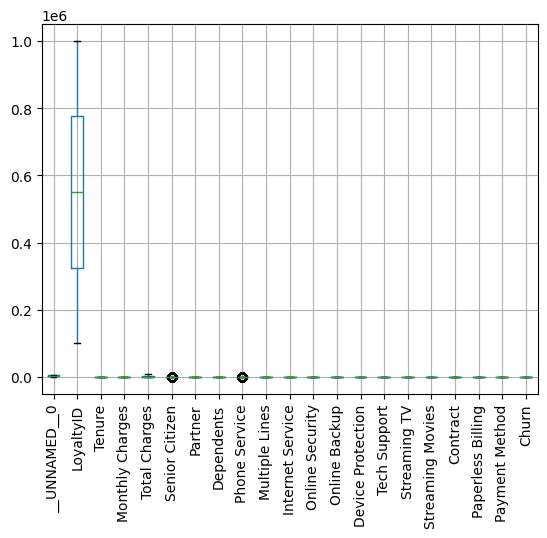

In [20]:
import matplotlib.pyplot as plt
df3.boxplot()
plt.xticks(rotation=90)
plt.show()

In [ ]:
df2.dtypes

# Duplicates

In [ ]:
temp=df3.duplicated()
duplicate_rows = df3[temp]
duplicate_rows.count()

No duplicates

# Class Balance

In [21]:
df3['Churn'].value_counts()

Churn
0.0    5163
1.0    1869
Name: count, dtype: int64

Classes are imbalanced. We will need to oversample the training data.

# Data split

In [22]:
X= df3.drop('Churn', axis=1)
Y= df3['Churn']
X_train, X_test, Y_train, Y_test= train_test_split(X,Y, random_state=42, test_size=0.2)
print('Train Size before oversampling: ', len(Y_train))

#initializing SMOTE 
oversampling= SMOTE(random_state=42)

# Now oversampling the training data
#Remember, for SMOTE, we don't need to specify the underrepresented class.
#It automatically detects. 
X_oversampled, Y_oversampled= oversampling.fit_resample(X_train, Y_train)
print('Train Size after oversampling: ', len(Y_oversampled))

Train Size before oversampling:  5625
Train Size after oversampling:  8260


In [23]:
np.unique(Y_oversampled, return_counts=True)

(array([0., 1.]), array([4130, 4130]))

Hence, we have balanced classes.

# Scaling

In [25]:
from sklearn.preprocessing import MinMaxScaler
scaler= MinMaxScaler()
X_train_scaled= scaler.fit_transform(X_oversampled)
X_test_scaled= scaler.fit_transform(X_test)

# Classifiers

We choose 3 classifiers:\
a) Logistic Regression
b) Random Forest
c) SVM



## a) Logistic Regression 

In [26]:
logistic_model = LogisticRegression()
model_logistic= logistic_model.fit(X_train_scaled, Y_oversampled)
logistic_predictions= model_logistic.predict(X_test_scaled)


# b) Random Forest

In [27]:
rf_model = RandomForestClassifier(random_state=42)
model_rf= rf_model.fit(X_train_scaled, Y_oversampled)
rf_predictions= model_rf.predict(X_test_scaled)

# c) Support Vectors

In [28]:
svc_model = SVC()
model_sv= svc_model.fit(X_train_scaled, Y_oversampled)
sv_predictions= model_sv.predict(X_test_scaled)

# Metrics

In [30]:
logistic_precision= precision_score(Y_test, logistic_predictions)
logistic_recall= recall_score(Y_test, logistic_predictions)
logistic_accuracy= accuracy_score(Y_test, logistic_predictions)
logistic_f1= f1_score(Y_test, logistic_predictions)

In [31]:
rg_precision= precision_score(Y_test, rf_predictions)
rg_recall= recall_score(Y_test, rf_predictions)
rg_accuracy= accuracy_score(Y_test, rf_predictions)
rg_f1= f1_score(Y_test, rf_predictions)

In [32]:
sv_precision= precision_score(Y_test, sv_predictions)
sv_recall= recall_score(Y_test,  sv_predictions)
sv_accuracy= accuracy_score(Y_test,  sv_predictions)
sv_f1= f1_score(Y_test,  sv_predictions)

In [33]:
print("Accuracy: \nLogistic: ",logistic_accuracy, "\nRandom Forest: ",rg_accuracy,"\nSVM: ",sv_accuracy)

Accuracy: 
Logistic:  0.7348969438521677 
Random Forest:  0.7860696517412935 
SVM:  0.7761194029850746


In [34]:
print("Precision: \nLogistic: ",logistic_precision, "\nRandom Forest: ",rg_precision,"\nSVM: ",sv_precision)

Precision: 
Logistic:  0.5008517887563884 
Random Forest:  0.6188925081433225 
SVM:  0.577023498694517


In [35]:
print("Recall: \nLogistic: ",logistic_recall, "\nRandom Forest: ",rg_recall,"\nSVM: ",sv_recall)

Recall: 
Logistic:  0.786096256684492 
Random Forest:  0.5080213903743316 
SVM:  0.5909090909090909


In [36]:
print("F1_score: \nLogistic: ",logistic_f1, "\nRandom Forest: ",rg_f1,"\nSVM: ",sv_f1)

F1_score: 
Logistic:  0.6118626430801248 
Random Forest:  0.5580029368575624 
SVM:  0.583883751651255


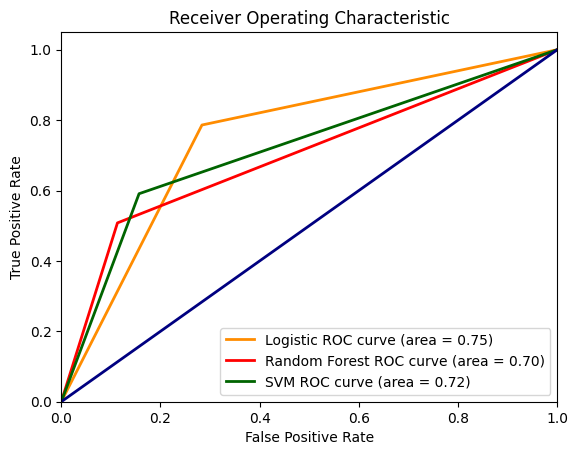

In [43]:
lfpr, ltpr, lthresholds = roc_curve(Y_test, logistic_predictions)
rfpr, rtpr, rthresholds = roc_curve(Y_test, rf_predictions)
sfpr, stpr, sthresholds = roc_curve(Y_test, sv_predictions)

lroc_auc=auc(lfpr, ltpr)
rroc_auc=auc(rfpr, rtpr)
sroc_auc=auc(sfpr, stpr)
#Plot ROC curve
plt.figure()
plt.plot(lfpr, ltpr, color='darkorange', lw=2, label=f'Logistic ROC curve (area = {lroc_auc:.2f})')
plt.plot(rfpr, rtpr, color='red', lw=2, label=f'Random Forest ROC curve (area = {rroc_auc:.2f})')
plt.plot(sfpr, stpr, color='darkgreen', lw=2, label=f'SVM ROC curve (area = {sroc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='-')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

In [45]:
from sklearn.model_selection import cross_val_score

In [47]:
lcv_scores= cross_val_score(logistic_model, X_train_scaled, Y_oversampled, cv=5)
rcv_scores= cross_val_score(rf_model, X_train_scaled, Y_oversampled, cv=5)
scv_scores= cross_val_score(svc_model, X_train_scaled, Y_oversampled, cv=5)



In [48]:
print("Mean Cross Validation score for logistic: ", lcv_scores.mean())
print("Mean Cross Validation score for Random Forest: ", rcv_scores.mean())
print("Mean Cross Validation score for SVM: ", scv_scores.mean())

Mean Cross Validation score for logistic:  0.7823244552058111
Mean Cross Validation score for Random Forest:  0.8404358353510896
Mean Cross Validation score for SVM:  0.82409200968523
